In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.20, count_rollouts: 5, reward: 0.3803681471851054, node: Fc1cccc(S(=O)(=O)N2CCC[C@H]2c2ccc(Cl)cc2)c1
1- time: 0.67, count_rollouts: 15, reward: 0.18844073284478277, node: CCC(=O)N(C)C[C@@H](O)C1CCCN(C(=O)c2ccccc2F)C1
2- time: 0.85, count_rollouts: 18, reward: 0.3022191311023372, node: c1cccc(O[C@@H](C)NC(=O)c2ccc(F)cc2F)c1
3- time: 1.00, count_rollouts: 21, reward: 0.41680582285556866, node: S=C(CCc1ccncc1)NCc1ccc(Cl)cc1Cl
4- time: 1.40, count_rollouts: 29, reward: 0.298024377379297, node: Sc1ccc(NC(=O)c2ccc(C(=O)N3CCC3)cc2)cc1
5- time: 1.51, count_rollouts: 31, reward: 0.37692451345206934, node: Fn1cc(Cc2ccccc2)c2ccccc21
6- time: 1.69, count_rollouts: 35, reward: -0.037831935431270794, node: OCC(=O)NCNC(=O)c1ccc(F)cc1
7- time: 1.80, count_rollouts: 38, reward: 0.3489169134844747, node: ClCN(CC(=O)NCCN1CCOc2ccccc21)c1cccc(C(F)F)c1
8- time: 2.22, count_rollouts: 47, reward: 0.19871080271924565, node: Cl[C@H](O)[C@H](CCO)c1nn(CCC(C)C)s1
9- time: 2.35, count_

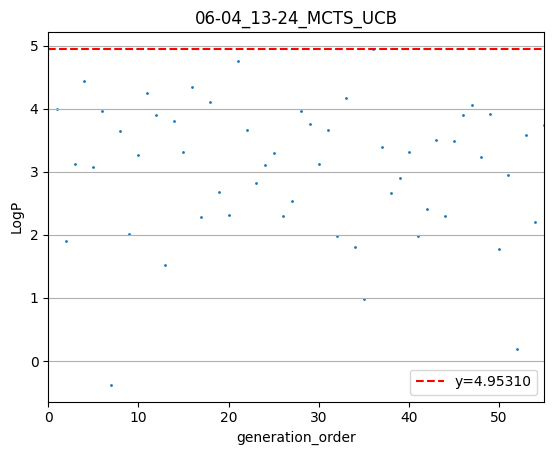

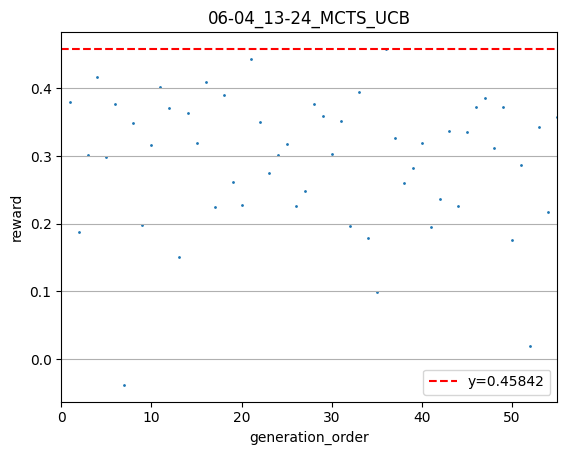

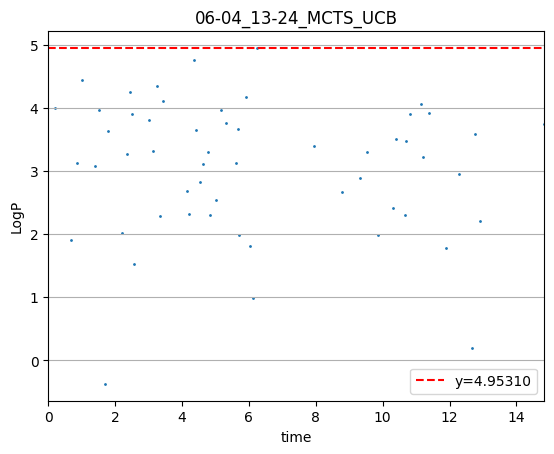

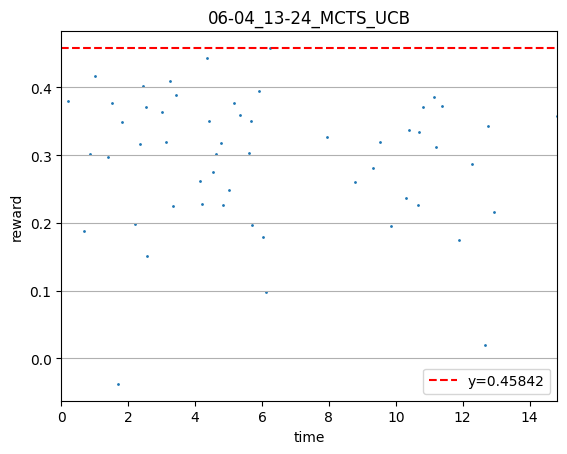

Search is completed.


In [8]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)